# 10. Trabalhando com Dados

### Explorando seus dados

* O primeiro passo, antes de ir mais a fundo e obter respostas, é explorar os dados.

#### Explorando dados unidimensionais

* Caso mais simples. 
* Quando se tem apenas uma coleção de números.
* O primeiro passo seria computar algumas estatísticas sumárias. Ex.: Quantos pontos de dados o conjunto tem? O maior, o menor, a média, o desvio padrão.
* Mas nem sempre só isso fornece um bom entendimento.
* O passo seguinte seria criar histogramas para agrupar os dados em buckets discretos e contar as frequências de cada grupo:

In [3]:
import math
from Codigos.linear_algebra import shape, get_row, get_column, make_matrix, vector_add, vector_subtract, vector_sum, scalar_multiply, vector_mean, dot, sum_of_squares, magnitude, distance
from Codigos.stats import mean, de_mean, variance, standard_deviation, covariance, correlation
from Codigos.probability import normal_pdf, normal_cdf, inverse_normal_cdf
from Codigos.gradient_descent import minimize_batch

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

# Reduz o ponto para o próximo múltiplo mais baixo de bucket_size
def bucketize(point, bucket_size): 
    return bucket_size*math.floor(point/bucket_size)

# agrupa os pontos e conta quantos em cada bucket
def make_histogram(points, bucket_size):
    return Counter(bucketize(point, bucket_size) for point in points)

# Mostra o Histograma a partir dos pontos
def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

In [5]:
# Consideremos agora os seguintes conjuntos de dados:
import random

random.seed(0)

# Uniforme entre -100 e 100
uniform = [200*random.random()-100 for _ in range(10000)]

# Distribuição normal com média 0, desvio padrão 57
normal = [57*inverse_normal_cdf(random.random()) 
          for _ in range(10000)]

* Ambas possuem médias próximas a 0 e desvios padrões próximos a 58.
* Possuem distribuições bem diferentes.
* As duas distribuições possuem max e min muito diferentes, embora isso não seja suficiente para entender porque são diferentes.
* Veja nos histogramas abaixo:

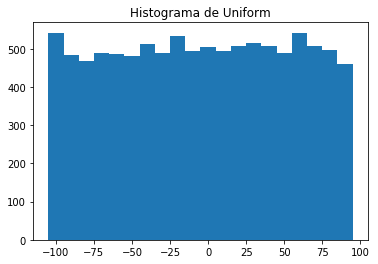

In [6]:
plot_histogram(uniform, 10, "Histograma de Uniform")

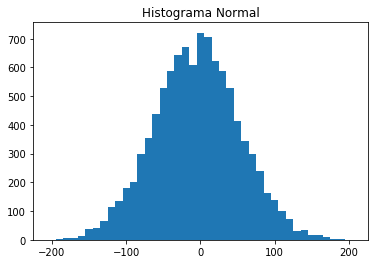

In [7]:
plot_histogram(normal, 10, "Histograma Normal")

#### Duas Dimensões

* Agora, imagine que o conjunto de dados possua duas dimensões. Por exemplo, você possui um conjunto com o tempo de uso de cada usuário do seu site e os anos de experiência do mesmo em data science.
* Você gostaria de entender cada dimensão individualmente, mas também deve querer dispersar os dados.
* Consideremos um outro conjunto de dados falso:

In [8]:
# Retorna o desenho aleatório de uma distribuição normal padrão
def random_normal():
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal()/2 for x in xs]
ys2 = [-x + random_normal()/2 for x in xs]

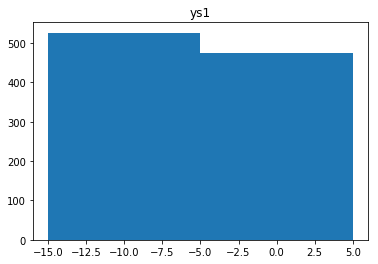

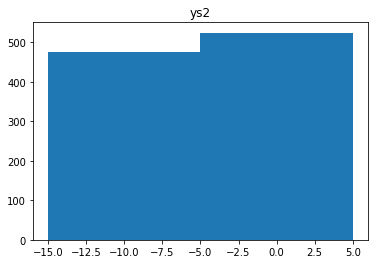

In [9]:
# Plotando ys1 e ys2, produzem gráficos muito parecidos
plot_histogram(ys1, 10, "ys1")
plot_histogram(ys2, 10, "ys2")

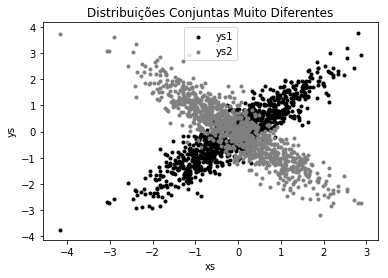

In [10]:
# Mas ambos possuem distribuições conjuntas diferentes com xs
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Distribuições Conjuntas Muito Diferentes")
plt.show()

In [11]:
# A diferença também ocorre no cálculo da correlação
print(correlation(xs, ys1))
print(correlation(xs, ys2))

0.9010493686379609
-0.8920981526880033


#### Muitas Dimensões

* Com muitas dimensões, gostaríamos de saber como essas dimensões se relacionam. 
* Uma abordagem simples é observar a matriz correlacional (correlation matrix):

In [12]:
def correlation_matrix(data):
    _, num_columns = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)

* Um abordagem visual é a matriz de gráfico de dispersão:

(-3.2918067620553195, 2.5499053643502396)

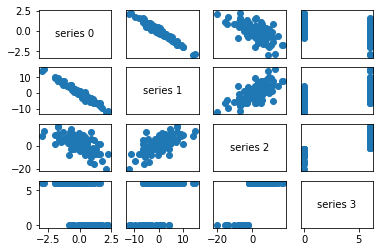

In [13]:
from typing import List

# Just some random data to show off correlation scatterplots
num_points = 100

def random_row() -> List[float]:
    row = [0.0, 0, 0, 0]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    return row

random.seed(0)
# each row has 4 points, but really we want the columns
corr_rows = [random_row() for _ in range(num_points)]

corr_data = [list(col) for col in zip(*corr_rows)]

# corr_data is a list of four 100-d vectors
num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):

        # Scatter column_j on the x-axis vs column_i on the y-axis,
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])

        # unless i == j, in which case show the series name.
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                xycoords='axes fraction',
                                ha="center", va="center")

        # Then hide axis labels except left and bottom charts
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)

# Fix the bottom right and top left axis labels, which are wrong because
# their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

#plt.show()

* Ao observar os gráficos, é possível inferir:
  * A série 1 é muito negativamente correlacionada com a série 0.
  * A série 2 é positivamente correlacionada com a série 1.
  * A série 3 somente aceita os valores 0 e 6, com 0 correspondendo aos valores menores da série 2 e 6 correspondendo aos maiores. 
* Essa é uma maneira rápida de ter uma ideia sobre como as variáveis são correlacionadas.

### Limpando e Transformando

* Os dados do mundo real são sujos.
* Na maioria das vezes será necessário trabalhar neles antes de usá-los. 
* É menos propício ao erro fazer a análise durante o fluxo de entrada de dados, ou seja, fazer uma função envolvendo o csv.reader e com uma lista de interpretadores para tratar cada coluna.
* None indica que nada deve ser feito em uma coluna. 

In [14]:
# Dada uma lista de interpretadores (alguns None), aplica o apropriado a cada elemento.
def parse_row(input_row, parsers):
    return [parser(value) if parder is not None else value
           for value, parser in zip(input_row, parsers)]

# Envolve um reader para aplicar os interpretadores em cada uma das linhas
def parse_rows_with(reader, parsers):
    for row in reader:
        yield parse_row(row, parsers)

* É necessário tratar os dados ruins para que ao invés de retornar uma exception, ele seja substituído por None:

In [15]:
# Função para tratar dados ruins
def try_or_none(f):
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

# Reescrevendo parse_row com o tratamento de dados ruins
def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
           for value, parser in zip(input_row, parsers)]

* Para os dados de preços de ações separados por vírgulas com dados ruins, agora é possível ler e analisar em um único passo.
* Em seguida é só buscar por linhas None e decidir o que fazer com elas.
  * Descartar;
  * Voltar a fonte e tantar consertar;
  * Não fazer nada.

In [16]:
import dateutil.parser
import csv

data = []

with open("Dados/comma_delimited_stock_prices.csv", "r") as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)
        
for row in data:
    if any(x is None for x in row):
        print(row)

[datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None]


* Também é possível criar uma função de tratamento semelhante a usada acima para tratar dados lidos utilizando csv.DictReader. 
* Para esse caso, os analisadores seriam fornecidos como um dict por meio de um nome de campo. 

In [56]:
def try_parse_field(field_name, value, parser_dict):
    parser = parser_dict.get(field_name) # None se não tiver tal entrada
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value

def parse_dict(input_dict, parser_dict):
    return {field_name : try_parse_field(field_name, value, parser_dict)
            for field_name, value in input_dict.items()}

* Uma próxima etapa seria checar por valores discrepantes.
* Os dados do mundo real têm pontos decimais faltosos, zeros extras, erros tipográficos e outros problemas incontáveis e é o seu trabalho capturá-los.

### Manipulando dados

* Uma habilidade importante para o cientista de dados.
* Trata-se de uma visão geral e não de uma técnica.

In [91]:
with open("Dados/stocks.txt", "r", encoding='utf8', newline='') as f:
        reader = csv.DictReader(f, delimiter="\t")
        data = [parse_dict(row, { 'date' : dateutil.parser.parse,
                                  'closing_price' : float })
                for row in reader]


* Vamos começar com perguntas sobre esses dados.
  * Padrões.
  * Ferramentas para facilitar a manipulação.


* Queremos saber o preço mais alto para a AAPL.
* Separando em etapas:
  1. Restringir em linhas AAPL;
  2. Pegar o closing_price de cada linha;
  3. Levar o max de tais preços.

In [92]:
max_aapl_price = max(row["closing_price"] 
                     for row in data 
                     if row["symbol"] == "AAPL")

print("AAPL max: {}".format(max_aapl_price))

AAPL max: 119.0


* Para saber o preço mais alto para cada ação no conjunto de dados:
  1. Agrupar as linhas com o mesmo symbol
  2. Dentro de cada grupo, encontrar closing_price max.

In [93]:
from collections import defaultdict
# Agrupa linhas por símbolo
by_symbol = defaultdict(list) 
for row in data:
    by_symbol[row["symbol"]].append(row)
    
# Encontra o valor máximo de cada símbolo usando dict
max_price_by_symbol = {symbol: max(row["closing_price"] 
                                  for row in grouped_rows)
                      for symbol, grouped_rows in by_symbol.items()}

In [94]:
for i in max_price_by_symbol:
    print(i, max_price_by_symbol[i])

AAPL 119.0
MSFT 49.3
FB 81.45


* Serão criadas duas funções abaixo:
  * Uma para pegar um campo específico de um dict.
  * Um para pegar o valor de um campo de uma lista de dicts.
  

* Uma terceira função que irá agrupar os dados baseado em alguma função de agrupamento e aplicar alguma transformação de valor.

In [95]:
# Pega um campo específico de um dict
def picker(field_name):
    return lambda row:row[field_name]

# Pega um campo específico em uma lista de dicts
def pluck(field_name, rows):
    return map(picker(field_name), rows)

# Agrupamento e aplicação de transformação de valores
def group_by(grouper, rows, value_transform=None):
    # a chave é a saída de grouper, o valor é uma lista de linhas
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if value_transform is None:
        return grouped
    else:
        return {key : value_transform(rows)
            for key, rows in grouped.items()}

In [96]:
# Reescrevendo o exemplo de agrupamento anterior
max_price_by_symbol = group_by(picker("symbol"),
                              data,
                              lambda rows: max(pluck("closing_price", rows)))

In [97]:
for i in max_price_by_symbol:
    print(i, max_price_by_symbol[i])

AAPL 119.0
MSFT 49.3
FB 81.45


* Queremos saber quais as maiores e menores mudanças de porcentagem ao dia no conjunto de dados.
* Dado por price_today/price_yesterday - 1.
* Para tal, é necessário:
  1. Ordenar os preços por data.
  2. Usar zip para ter pares (anteriores, atuais).
  3. Tranformar os pares em linhas novas de mudança de percentual.
  
  
* Iniciamos com funções para dentro de cada grupo:

In [98]:
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # organiza as linhas por data
    ordered = sorted(grouped_rows, key=picker("date"))
    # compacta com uma compensação para ter pares de dias consecutivos
    return [{"symbol" : today["symbol"],
             "date" : today["date"],
             "change" : percent_price_change(yesterday, today)}
            for yesterday, today in zip(ordered, ordered[1:])]

* Depois podemos aplicar a função group_by como um value transform: 

In [102]:
# a chave é symbol, o valor é uma change de dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)
# coleta todas as changes de dicts para uma lista grande
all_changes = [change
               for changes in changes_by_symbol.values()
               for change in changes]

# E então encontramos o maior e o menor
print(max(all_changes, key=picker("change")))
print(min(all_changes, key=picker("change")))

{'symbol': 'AAPL', 'date': datetime.datetime(1997, 8, 6, 0, 0), 'change': 0.3283582089552237}
{'symbol': 'AAPL', 'date': datetime.datetime(2000, 9, 29, 0, 0), 'change': -0.5193370165745856}


* Por fim podemos utilizar o novo dataset (all_changes) para definir o melhor mês para investir em ações tecnológicas:

In [126]:
from functools import reduce, partial
# para combinar as mudanças percentuais, adicionamos 1 a cada um, os multiplicamos
# e subtraímos 1 por exemplo, se combinarmos +10% e –20%, a mudança geral é
# (1 + 10%) * (1 - 20%) - 1 = 1.1 * .8 - 1 = -12%
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row['date'].month, 
                                   all_changes, 
                                   overall_change)

In [108]:
print("Overall_change_by_month: ")
for i in overall_change_by_month:
    print(i, overall_change_by_month[i])

Overall_change_by_month: 
12 2.2895332950255933
1 19.972214514609085
2 0.11858483359215
3 2.818850048603327
4 6.9341967849847626
5 1.2555660890321603
6 -0.5977889232201744
7 -0.17183091713561482
8 6.220055959879489
9 -0.741162543642831
10 21.552541251680015
11 3.758572336791725


### Redimensionando

* Muitas técnicas são sensíveis a escala dos seus dados.
* Se a mudança de unidades muda os resultados, temos um grande problema.
* Quando as dimensões não são comparáveis, devemos redimensionar os dados para que cada dimensão possua média 0 e desvio padrão 1. 
  * Nos livra das unidades, pois cada dimensão é convertida para "desvios padrões a partir da média".


* Inicialmente devemos calcular a média e o desvio padrão para cada coluna dos dados e em seguida, usamos as medidas para criar a nova matriz:

In [109]:
# Cálculo da média e do desvio padrão
def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix, j))
            for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix, j))
             for j in range(num_cols)]
    return means, stdevs

# Redimensiona os dados e cria nova matriz de dados
def rescale(data_matrix):
    means, stdevs = scale(data_matrix)
    
    def rescaled(i,j):
        if stdevs[j] > 0:
            return (data_matrix[i][j]-means[j])/stdevs[j]
        else:
            return data_matrix[i][j]
    
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

### Redução de dimensionalidade

* As vezes, as dimensões "reais" dos dados podem não corresponder com as que temos. 
* Observe o gráfico:

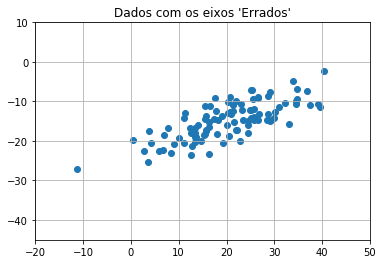

In [118]:
X = [[20.9666776351559,-13.1138080189357], [22.7719907680008,-19.8890894944696],
[25.6687103160153,-11.9956004517219], [18.0019794950564,-18.1989191165133],
[21.3967402102156,-10.8893126308196], [0.443696899177716,-19.7221132386308],
[29.9198322142127,-14.0958668502427], [19.0805843080126,-13.7888747608312],
[16.4685063521314,-11.2612927034291], [21.4597664701884,-12.4740034586705],
[3.87655283720532,-17.575162461771], [34.5713920556787,-10.705185165378],
[13.3732115747722,-16.7270274494424], [20.7281704141919,-8.81165591556553],
[24.839851437942,-12.1240962157419], [20.3019544741252,-12.8725060780898],
[21.9021426929599,-17.3225432396452], [23.2285885715486,-12.2676568419045],
[28.5749111681851,-13.2616470619453], [29.2957424128701,-14.6299928678996],
[15.2495527798625,-18.4649714274207], [26.5567257400476,-9.19794350561966],
[30.1934232346361,-12.6272709845971], [36.8267446011057,-7.25409849336718],
[32.157416823084,-10.4729534347553], [5.85964365291694,-22.6573731626132],
[25.7426190674693,-14.8055803854566], [16.237602636139,-16.5920595763719],
[14.7408608850568,-20.0537715298403], [6.85907008242544,-18.3965586884781],
[26.5918329233128,-8.92664811750842],[-11.2216019958228,-27.0519081982856],
[8.93593745011035,-20.8261235122575],[24.4481258671796,-18.0324012215159],
[2.82048515404903,-22.4208457598703],[30.8803004755948,-11.455358009593],
[15.4586738236098,-11.1242825084309],[28.5332537090494,-14.7898744423126],
[40.4830293441052,-2.41946428697183],[15.7563759125684,-13.5771266003795],
[19.3635588851727,-20.6224770470434],[13.4212840786467,-19.0238227375766],
[7.77570680426702,-16.6385739839089],[21.4865983854408,-15.290799330002],
[12.6392705930724,-23.6433305964301],[12.4746151388128,-17.9720169566614],
[23.4572410437998,-14.602080545086],[13.6878189833565,-18.9687408182414],
[15.4077465943441,-14.5352487124086],[20.3356581548895,-10.0883159703702],
[20.7093833689359,-12.6939091236766],[11.1032293684441,-14.1383848928755],
[17.5048321498308,-9.2338593361801],[16.3303688220188,-15.1054735529158],
[26.6929062710726,-13.306030567991],[34.4985678099711,-9.86199941278607],
[39.1374291499406,-10.5621430853401],[21.9088956482146,-9.95198845621849],
[22.2367457578087,-17.2200123442707],[10.0032784145577,-19.3557700653426],
[14.045833906665,-15.871937521131],[15.5640911917607,-18.3396956121887],
[24.4771926581586,-14.8715313479137],[26.533415556629,-14.693883922494],
[12.8722580202544,-21.2750596021509],[24.4768291376862,-15.9592080959207],
[18.2230748567433,-14.6541444069985],[4.1902148367447,-20.6144032528762],
[12.4332594022086,-16.6079789231489],[20.5483758651873,-18.8512560786321],
[17.8180560451358,-12.5451990696752],[11.0071081078049,-20.3938092335862],
[8.30560561422449,-22.9503944138682],[33.9857852657284,-4.8371294974382],
[17.4376502239652,-14.5095976075022],[29.0379635148943,-14.8461553663227],
[29.1344666599319,-7.70862921632672],[32.9730697624544,-15.5839178785654],
[13.4211493998212,-20.150199857584],[11.380538260355,-12.8619410359766],
[28.672631499186,-8.51866271785711],[16.4296061111902,-23.3326051279759],
[25.7168371582585,-13.8899296143829],[13.3185154732595,-17.8959160024249],
[3.60832478605376,-25.4023343597712],[39.5445949652652,-11.466377647931],
[25.1693484426101,-12.2752652925707],[25.2884257196471,-7.06710309184533],
[6.77665715793125,-22.3947299635571],[20.1844223778907,-16.0427471125407],
[25.5506805272535,-9.33856532270204],[25.1495682602477,-7.17350567090738],
[15.6978431006492,-17.5979197162642],[37.42780451491,-10.843637288504],
[22.974620174842,-10.6171162611686],[34.6327117468934,-9.26182440487384],
[34.7042513789061,-6.9630753351114],[15.6563953929008,-17.2196961218915],
[25.2049825789225,-14.1592086208169]]

x, y = list(zip(*X)) 

plt.scatter(x, y)
plt.title("Dados com os eixos 'Errados'")
plt.axis([-20,50,-45,10])
plt.grid()
plt.show()

* A maioria das variações nos dados parecem ser de uma única dimensão que não correponde ao eixo x nem ao eixo y.
* Podemos usar a técnica de análise de componentes principais para extrais uma ou mais dimensões que capturem a maior variação dos dados.
  * Geralmente não é utilizada em dados com poucas dimensões.


* A implementação é feita e explicada abaixo:

In [119]:
# Inicialmente os dados são transformados para que cada dimensão tenha média 0
def de_mean_matrix(A):
    # Retorna a subtração de cada valor em A pela média de sua coluna
    # A matriz resultante tem média 0 em todas as colunas
    
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])


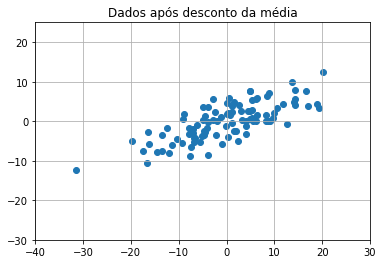

In [125]:
x, y = list(zip(*de_mean_matrix(X)))

plt.scatter(x, y)
plt.title("Dados após desconto da média")
plt.axis([-40,30,-30,25])
plt.grid()
plt.show()

In [135]:
# Após o desconto da média, calculamos a direção que captura a maior variação nos dados.
# Dada uma direção d, cada linha x na matriz se estende dot(x, d) na direção de d.
def direction(w):
    mag = magnitude(w)
    return [w_i/mag for w_i in w]

# Dado o vetor não-zero w, podemos computar a variância do conjunto de dados.
# Variância na linha x_i na direção determinada por w.
def directional_variance_i(x_i, w):
    return dot(x_i, direction(w))**2

# Variância dos dados na direção w 
def directional_variance(X, w):
    return sum(directional_variance_i(x_i, w)
              for x_i in X)

# Precisamos encontrar a direção que maximiza a variância.
# Para isso usamos o gradiente descente, assim que tivermos a função gradiente
def directional_variance_gradient_i(x_i, w):
    """a contribuição da linha x_1 para o gradiente da
    variância da direção w"""
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i,w)
                      for x_i in X)

# O componente principal é a direção que maximiza a variância
def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X), # agora é uma função de w
        partial(directional_variance_gradient, X), # agora é uma função de w
        guess)
    
    return direction(unscaled_maximizer)

# Com o primeiro componente, podemos projetar os dados
def project(v, w):
    """retorna a projeção de v na direção w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

# Para encontrar componentes mais distantes, 
# é necessário remover as projeções a partir dos dados
def remove_projection_from_vector(v, w):
    """projeta v em w e subtrai o resultado de v"""
    return vector_subtract(v, project(v, w))

def remove_projection(X, w):
    """para cada linha de X
    projeta a linha em w, e subtrai o resultado da linha"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]

w = first_principal_component(X)
A = remove_projection(X,w)

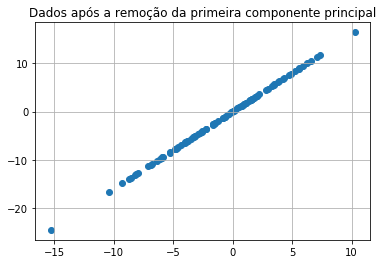

In [137]:
x, y = list(zip(*A))

plt.scatter(x, y)
plt.title("Dados após a remoção da primeira componente principal")
#plt.axis([-40,30,-30,25])
plt.grid()
plt.show()

In [139]:
# Em um conjunto de dados de dimensão mais alta, podemos 
# encontrar tantos componentes quanto quisermos:
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
    return components

#Podemos então transformar nossos dados no espaço de 
# dimensão mais baixa coberto pelos componentes:
def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]

* Essa técnica é valiosa por dois motivos:
  * Primeiro:
    * Pode nos ajudar a limpar nossos dados ao eliminar dimensões que são mero ruído e; 
    * Consolidar dimensões que são altamente correlacionadas.
  * Segundo:
    * Após extrair uma representação de dimensão mais baixa dos nossos dados, podemos usar uma variedade de técnicas que não funcionam bem em dados de alta dimensão.


* enquanto pode ajudar a construir modelos melhores, também pode torná-los mais difíceis de serem interpretados.